<a href="https://colab.research.google.com/github/ZonaQuant/Notebooks/blob/main/REGIMEN_CON_K_MEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. FILTRO DE RÉGIMEN CON K-MEANS Y XGBOOST

Utilizamos k-means para generar el etiquetado con el que entrenamos XGboost.


#1. LIBRERÍAS

In [ ]:
!pip install yfinance 
import yfinance as yf
!pip install talib-binary
import talib as tl
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 6.8 MB/s 


#2. FUNCIÓN PARA DESCARGAR HISTÓRICOS

In [ ]:
def historico(ticker, days):
    today = datetime.today()
    initial = today - dt.timedelta(days=days)
    today = today.strftime('%Y-%m-%d')
    initial = initial.strftime('%Y-%m-%d')
    data = yf.download(ticker, start=initial, end=today, progress=False)
    return data

#3. FUNCIÓN PARA CALCULAR INDICADORES

In [ ]:
def indicators(data):
    high = np.array(data["high"])
    low = np.array(data["low"])
    close = np.array(data["close"])
    ta = []
    columns = []   
    periods = list(range(5,50))

    # AROON
    for n in periods:
        name_up = "AROONUpper" + str(n)
        name_down = "AROONLower" + str(n)
        aroondown, aroonup = tl.AROON(high, low, timeperiod=n)
        ta.append(pd.Series(aroonup))
        ta.append(pd.Series(aroondown))
        columns.append(name_up)
        columns.append(name_down)
    # AROONOSC
    for n in periods:
        name = "AROONOSC" + str(n)  
        aroonosc = tl.AROONOSC(high, low, timeperiod=n)
        ta.append(pd.Series(aroonosc))
        columns.append(name)
    # CCI - Commodity Channel Index
    for n in periods:
        name = "CCI" + str(n)
        ta.append(pd.Series(tl.CCI(high, low, close, timeperiod=n)))
        columns.append(name)
    # CMO - Chande Momentum Oscillator
    for n in periods:
        name = "CMO" + str(n)
        ta.append(pd.Series(tl.CMO(close, timeperiod=n)))
        columns.append(name) 
    # RSI - Relative Strength Index
    for n in periods:
        name = "RSI" + str(n)
        ta.append(pd.Series(tl.RSI(close, timeperiod=n)))
        columns.append(name)    
    # STOCH - Stochastic
    for n in periods:
        name_k = "STOCHK" + str(n)
        name_d = "STOCHD" + str(n)
        fastk, fastd = tl.STOCHF(high, low, close, fastk_period=n, fastd_period=3, fastd_matype=0)
        ta.append(pd.Series(fastk))        
        columns.append(name_k)   
        ta.append(pd.Series(fastd))        
        columns.append(name_d)   
    # STOCHRSI - Stochastic Relative Strength Index
    for n in periods:
        name_k = "STOCHRSIK" + str(n)
        name_d = "STOCHRSID" + str(n)
        fastk, fastd = tl.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        ta.append(pd.Series(fastk))        
        columns.append(name_k)   
        ta.append(pd.Series(fastd))        
        columns.append(name_d) 
    # WILLR - Williams' %R
    for n in periods:
        name = "WILLR" + str(n)
        ta.append(pd.Series(tl.WILLR(high, low, close, timeperiod=n)))
        columns.append(name)

    # ADX
    for n in [5,10,15,20,25]:
        name = "ADX" + str(n)
        ta.append(pd.Series(tl.ADX(high, low, close, timeperiod=n)))
        columns.append(name)
    # ADXR
    for n in [5,10,15]:
        name = "ADXR" + str(n)
        ta.append(pd.Series(tl.ADXR(high, low, close, timeperiod=n)))
        columns.append(name)
    # DX - Directional Movement Index
    for n in periods:
        name = "DX" + str(n)
        ta.append(pd.Series(tl.DX(high, low, close, timeperiod=n)))
        columns.append(name)    
    # MACD - Moving Average Convergence/Divergence
    for n in periods:
        name = "MACD" + str(n)
        macd, macdsignal, macdhist = tl.MACD(close, fastperiod=int(n/2), slowperiod=n, signalperiod=9)
        ta.append(pd.Series(macd))
        columns.append(name)      
    # MINUS_DI - Minus Directional Indicator
    for n in periods:
        name = "DI" + str(n)
        ta.append(pd.Series(tl.MINUS_DI(high, low, close, timeperiod=n)))
        columns.append(name)  
    # MINUS_DM - Minus Directional Movement
    for n in periods:
        name = "DM" + str(n)
        ta.append(pd.Series(tl.MINUS_DM(high, low, timeperiod=n)))
        columns.append(name)      
    # MOM - Momentum
    for n in periods:
        name = "MOM" + str(n)
        ta.append(pd.Series(tl.MOM(close, timeperiod=n)))
        columns.append(name)      
    # PLUS_DI - Plus Directional Indicator
    for n in periods:
        name = "PDI" + str(n)
        ta.append(pd.Series(tl.PLUS_DI(high, low, close, timeperiod=n)))
        columns.append(name)
    # PLUS_DM - Plus Directional Movement
    for n in periods:
        name = "PDM" + str(n)
        ta.append(pd.Series(tl.PLUS_DM(high, low, timeperiod=n)))
        columns.append(name)    
    # ROC - Rate of change : ((price/prevPrice)-1)*100
    for n in periods:
        name = "ROC" + str(n)
        ta.append(pd.Series(tl.ROC(close, timeperiod=n)))
        columns.append(name)        
    # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
    for n in periods:
        name = "ROCP" + str(n)
        ta.append(pd.Series(tl.ROCP(close, timeperiod=n)))
        columns.append(name) 
    # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA    
    for n in [5,10,15]:
        name = "TRIX" + str(n)
        ta.append(pd.Series(tl.TRIX(close, timeperiod=n)))
        columns.append(name)   

    df = pd.concat(ta, axis=1)
    df.columns = columns
    return df

#4. FUNCIÓN PARA GENERAR CLÚSTERS CON K-MEANS

In [ ]:
def clusters(ticker, days):
  datos = historico(ticker, days)
  datos.columns = ["open", "high", "low", "close", "adj close", "volume"]

  features = indicators(datos)
  features.index = datos.index
  features["close"] = datos["close"]
  features = features.dropna()
  X = features.iloc[:,:-1]
  Y = features.iloc[:,-1]
  ss = StandardScaler()
  X_scaled = ss.fit_transform(X)

  kmeans = KMeans(n_clusters=2).fit(X_scaled)
  labels = kmeans.predict(X_scaled)
  df = pd.DataFrame()
  df.index = features.index
  df["labels"] = labels
  df["close"] = Y

  return df

#5. FUNCIÓN PARA GENERAR EL DATASET

In [ ]:
def dataset(ticker, days):
  df = clusters(ticker, days)

  datos = historico(ticker, days)
  datos.columns = ["open", "high", "low", "close", "adj close", "volume"]

  features = indicators(datos)
  features.index = datos.index
  features["close"] = datos["close"]
  features = features.iloc[(len(features)-len(df)):,:]

  dataset = features
  dataset["label"] = df["labels"].shift(-5)
  dataset = dataset.dropna()

  return dataset

##5.1 EJEMPLO NASDAQ





In [ ]:
data = dataset("^NDX", 4380)

data

,AROONUpper5,AROONLower5,AROONUpper6,AROONLower6,AROONUpper7,AROONLower7,AROONUpper8,AROONLower8,AROONUpper9,AROONLower9,...,ROCP45,ROCP46,ROCP47,ROCP48,ROCP49,TRIX5,TRIX10,TRIX15,close,label
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-11,100.0,0.0,100.000000,0.000000,100.000000,14.285714,100.0,0.0,100.000000,0.000000,...,0.081137,0.086692,0.086464,0.085790,0.088706,0.284404,0.170715,0.158365,2379.149902,1.0
2011-02-14,100.0,0.0,100.000000,0.000000,100.000000,0.000000,100.0,12.5,100.000000,0.000000,...,0.083590,0.084068,0.089638,0.089410,0.088733,0.295843,0.183849,0.163556,2385.600098,1.0
2011-02-15,80.0,40.0,83.333333,0.000000,85.714286,0.000000,87.5,0.0,88.888889,11.111111,...,0.075194,0.081919,0.082396,0.087958,0.087729,0.286550,0.193791,0.168399,2381.919922,0.0
2011-02-16,100.0,20.0,100.000000,33.333333,100.000000,0.000000,100.0,0.0,100.000000,0.000000,...,0.086294,0.082425,0.089195,0.089675,0.095275,0.288105,0.204075,0.173823,2397.939941,0.0
2011-02-17,80.0,0.0,83.333333,16.666667,85.714286,28.571429,87.5,0.0,88.888889,0.000000,...,0.083603,0.086127,0.082258,0.089027,0.089507,0.280990,0.212267,0.179007,2397.570068,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-07,20.0,80.0,33.333333,83.333333,42.857143,85.714286,0.0,87.5,0.000000,88.888889,...,-0.092693,-0.105716,-0.105527,-0.110648,-0.120737,-0.431268,-0.083042,-0.157189,10977.000000,1.0
2022-11-08,0.0,60.0,16.666667,66.666667,28.571429,71.428571,37.5,75.0,0.000000,77.777778,...,-0.079243,-0.085874,-0.098995,-0.098804,-0.103964,-0.367020,-0.102304,-0.156340,11059.500000,1.0
2022-11-09,0.0,40.0,0.000000,50.000000,14.285714,57.142857,25.0,62.5,33.333333,66.666667,...,-0.119242,-0.101051,-0.107525,-0.120335,-0.120150,-0.366790,-0.126547,-0.158780,10797.549805,1.0


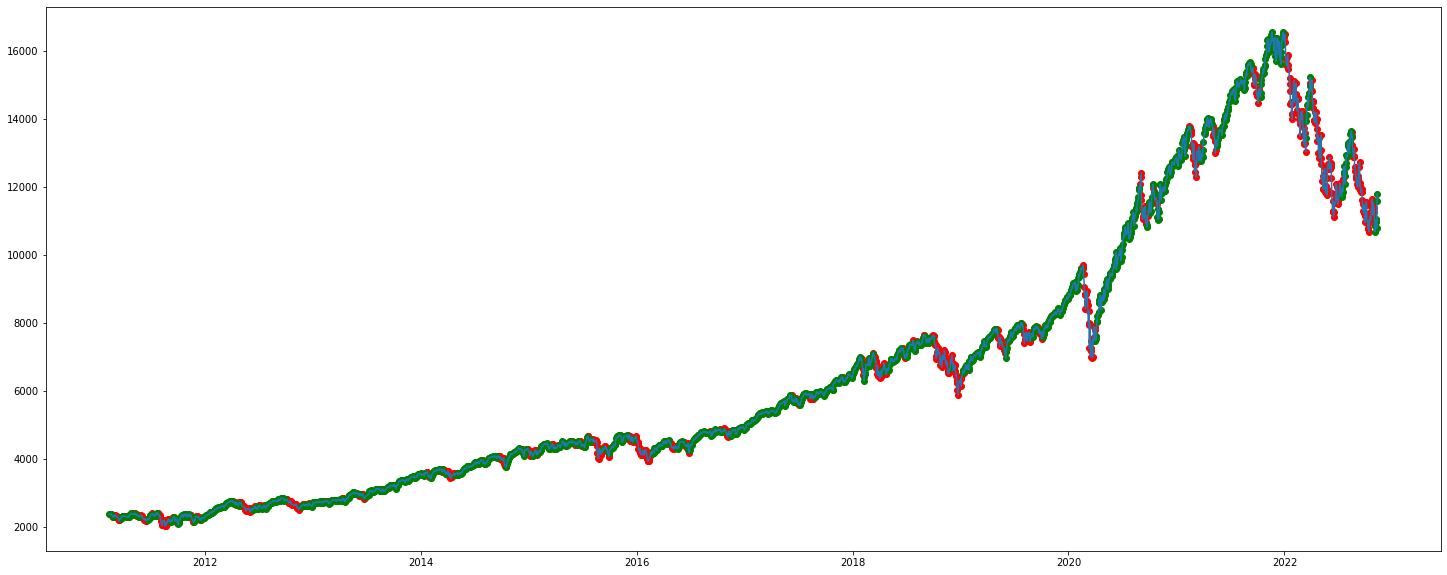

In [ ]:
zero = data[data["label"]==0]
one = data[data["label"]==1]

fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.scatter(zero.index, zero["close"], c = "red")
ax.scatter(one.index, one["close"], c = "green")
ax.plot(data.index, data["close"])
plt.show()

#6. PARTICIÓN DEL DATASET

Separamos el dataset en 3 periodos: train, test y validation.

De esta manera nos aseguramos de que el modelo no ha sido entrenado con los datos de validación, que serán los más recientes.

El train tendrá una longitud igual a 7 veces el validation.

El test tendrá una longitud igual a 3 veces el validation.

In [ ]:
inicio_train = 0
final_train = round(7*len(data)/11)
final_test = final_train + round(3*len(data)/11)

In [ ]:
#DATOS DE ENTRENAMIENTO
train = data.iloc[inicio_train:final_train]
print("Longitud de los datos de entrenamiento:", len(train))

Longitud de los datos de entrenamiento: 1883


In [ ]:
#DATOS DE TEST
test = data.iloc[final_train:final_test]
print("Longitud de los datos de test:", len(test))

Longitud de los datos de test: 807


In [ ]:
#DATOS DE VALIDACIÓN
validation = data.iloc[final_test:]
print("Longitud de los datos de validación: ", len(validation))

Longitud de los datos de validación:  269


#7. SELECCIÓN DE FEATURES

De las más de 900 features seleccionaremos las 50 con mayor importancia según un Random Forest para simplificar el modelo final.

Para ello utilizaremos los datos de train y test.

In [ ]:
#CONCATENAMOS TRAIN Y TEST
in_sample = pd.concat([train,test])

#SEPARAMOS FEATURES Y LABELS
X = in_sample.iloc[:,0:-2]
Y = in_sample.iloc[:,-1]

In [ ]:
#ENTRENAMOS EL RANDOM FOREST EN EL PERIODO TRAIN+TEST
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000)
model.fit(X, Y)

RandomForestClassifier(n_estimators=1000)

In [ ]:
#SELECCIONAMOS LAS FEATURES MÁS IMPORTANTES SEGÚN RANDOM FOREST
df_features = pd.DataFrame({"features": X.columns.values, "importancias": model.feature_importances_})
df_features = df_features.sort_values("importancias", ascending=False)

df_features = df_features.head(50)

df_features.head(5)

,features,importancias
156,CCI26,0.008011
157,CCI27,0.007970
159,CCI29,0.007835
237,RSI17,0.007706
236,RSI16,0.007692


In [ ]:
#REDUCIMOS EL DATASET TRAIN A LAS FEATURES SELECCIONADAS
train_50 = train.loc[:,list(df_features["features"])]
train_50["close"] = train["close"]
train_50["label"] = train["label"]

#REDUCIMOS EL DATASET TEST A LAS FEATURES SELECCIONADAS
test_50 = test.loc[:,list(df_features["features"])]
test_50["close"] = test["close"]
test_50["label"] = test["label"]

#REDUCIMOS EL DATASET VALIDATION A LAS FEATURES SELECCIONADAS
validation_50 = validation.loc[:,list(df_features["features"])]
validation_50["close"] = validation["close"]
validation_50["label"] = validation["label"]

#8. XGBOOST

Finalmente, entrenamos el modelo supervisado con los datos de entrenamiento con el labeling obtenido a base de k-means y lo probamos en los datos de test.

In [ ]:
#SEPARAMOS FEATURES Y LABELS
X_train = train_50.iloc[:,0:-2]
Y_train = train_50.iloc[:,-1]

X_test = test_50.iloc[:,0:-2]
Y_test = test_50.iloc[:,-1]

X_validation = validation_50.iloc[:,0:-2]
Y_validation = validation_50.iloc[:,-1]

In [ ]:
#ENTRENAMOS EL MODELO 
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier()

In [ ]:
#GENERAMOS PREDICCIONES DEL MODELO CON DATOS DE TEST
predicciones = model.predict(X_test)
test_50["predicciones"] = predicciones

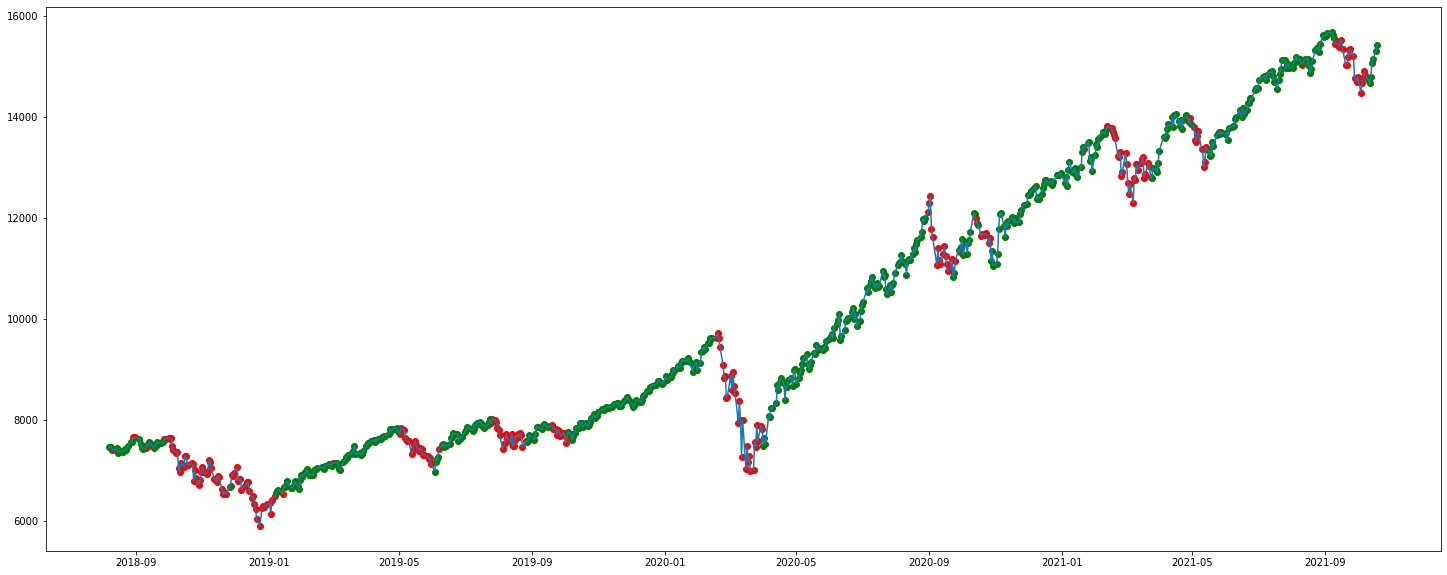

In [ ]:
#GRAFICAMOS LOS RESULTADOS DEL MODELO EN EL PERIODO DE TEST
zero = test_50[test_50["label"]==0]
one = test_50[test_50["label"]==1]

fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.scatter(zero.index, zero["close"], c = "red")
ax.scatter(one.index, one["close"], c = "green")
ax.plot(test_50.index, test_50["close"])
plt.show()

El modelo generado con datos de entrenamiento sigue marcando las tendencias con precisión con datos de test.

#9. DATOS FUERA DE MUESTRA

A continuación, mostramos los resultados del modelo con datos que no han sido utilizados ni para entrenar ni para testar el modelo.

In [ ]:
#GENERAMOS PREDICCIONES DEL MODELO CON DATOS DE VALIDACIÓN
predicciones = model.predict(X_validation)
validation_50["predicciones"] = predicciones

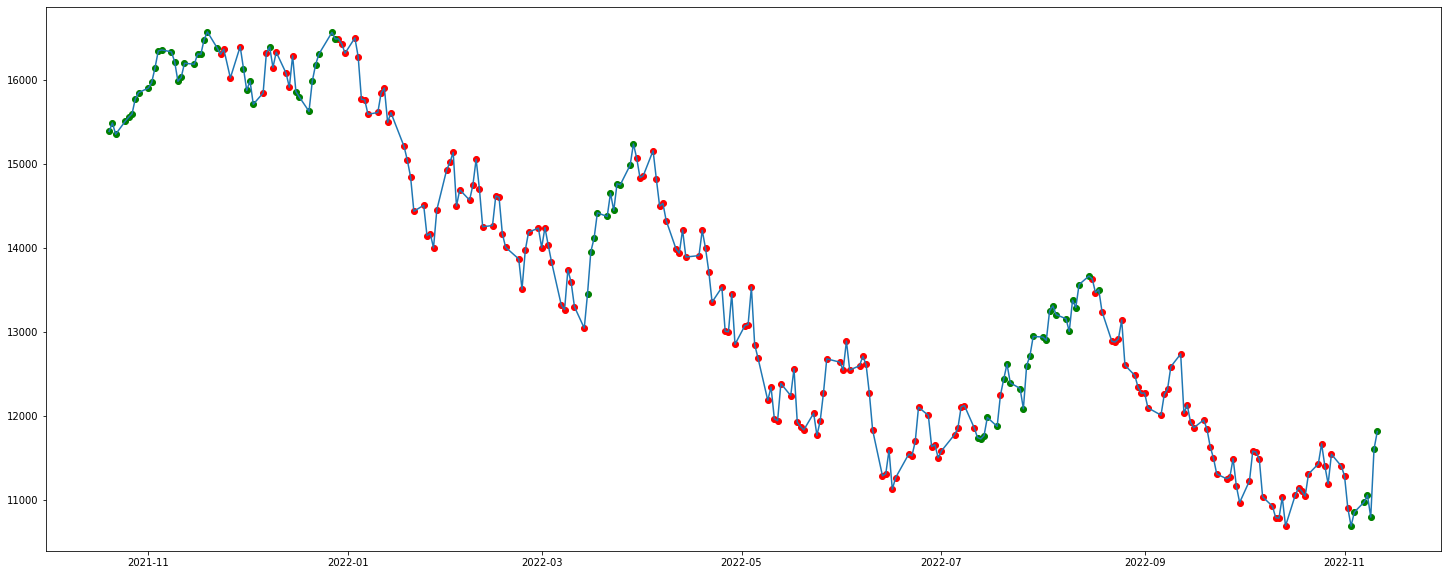

In [ ]:
#GRAFICAMOS LOS RESULTADOS DEL MODELO EN EL PERIODO DE TEST
zero = validation_50[validation_50["label"]==0]
one = validation_50[validation_50["label"]==1]

fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.scatter(zero.index, zero["close"], c = "red")
ax.scatter(one.index, one["close"], c = "green")
ax.plot(validation_50.index, validation_50["close"])
plt.show()